In [1]:
%matplotlib inline
%load_ext autoreload 
%autoreload 2

from __future__ import division

import numpy as np
import os
#import mne
import pandas as pd
import matplotlib.pyplot as plt

from scipy import io, signal

from data_utils import *
from preprocessing import *
from models import *
from metrics import *

from sklearn.linear_model import LogisticRegression as LR
from sklearn import svm

#from keras.models import Sequential
#from keras.layers.core import Dense, Dropout, Activation, Flatten
#from keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score

no cv2... continuing...


Using Theano backend.
Using gpu device 0: Tesla K20c (CNMeM is disabled, cuDNN Version is too old. Update to v5, was 3007.)


In [159]:
path = '/home/UFAD/yliapis/data/karaOne/MM05/all_features_noICA.mat'
all_features = io.loadmat(path)

In [160]:
eeg = all_features['all_features']['eeg_features'][0,0][0,0]
eeg.dtype


dtype([('thinking_feats', 'O'), ('clearing_feats', 'O'), ('stimuli_feats', 'O'), ('speaking_feats', 'O')])

In [161]:
f_dict = all_features['all_features']['feature_labels'][0,0].flatten()
f_dict = np.concatenate(f_dict)

from itertools import product
full_dict = ['ch'+str(i)+'_'+f for i,f in product(range(62), f_dict)]
print len(full_dict)

74214


In [162]:
print np.shape(X_train)

(240, 74214)


In [163]:
eeg = all_features['all_features']['eeg_features'][0,0][0,0]

f_spk = [m.squeeze() for m in eeg['speaking_feats'].squeeze()]
f_clr = [m.squeeze() for m in eeg['clearing_feats'].squeeze()]
f_thk = [m.squeeze() for m in eeg['thinking_feats'].squeeze()]
f_stm = [m.squeeze() for m in eeg['stimuli_feats'].squeeze()]

In [164]:
f1, f0 = f_stm, f_clr
f1, f0 = rec_map(lambda x: x.reshape(-1), [f1, f0], 2)

y1, y0 = np.ones(len(f1)), np.zeros(len(f0))

X_train, X_test = f1[:120]+f0[:120], f1[120:]+f0[120:]
Y_train, Y_test = np.concatenate([y1[:120], y0[:120]]), \
                    np.concatenate([y1[120:], y0[120:]])

In [165]:
def normalize(vects):
    stds = np.std(vects, axis=0)[None,:]
    means = np.mean(vects, axis=0)[None,:]
    vect = (vects-means)/(2*stds)
    vect = np.nan_to_num(vect)
    return vect #np.maximum(stds,.00001)

X_train, X_test = map(normalize, [X_train, X_test])

In [48]:
# feature selection
from sklearn.feature_selection import SelectFromModel

clf = svm.SVC(kernel='linear', cache_size=1000)
sfm = SelectFromModel(clf, threshold=None)
sfm.fit(X_train, Y_train)

n_features = sfm.transform(X_train).shape[1]
print n_features

model = svm.SVC(kernel='linear', cache_size=1000)

model.fit(sfm.transform(X_train), Y_train)

print accuracy_score(Y_train, model.predict(sfm.transform(X_train)))
print accuracy_score(Y_test, model.predict(sfm.transform(X_test)))

18179
1.0
0.916666666667


In [23]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

skb = SelectKBest(mutual_info_classif, k=100)

skb.fit(X_train, Y_train)


SelectKBest(k=100,
      score_func=<function mutual_info_classif at 0x7f1dd3852e60>)

In [24]:
XX_train = skb.transform(X_train)
XX_test = skb.transform(X_test)

model = svm.SVC(kernel='linear', cache_size=1000)

model.fit(XX_train, Y_train)

print accuracy_score(Y_train, model.predict(XX_train))
print accuracy_score(Y_test, model.predict(XX_test))

0.9875
0.708333333333


In [41]:

idxs = skb.transform([range(X_train[0].shape[0])])[0]

feats = [full_dict[i] for i in idxs]

print feats

[u'ch0_SE:W1', u'ch0_SE:W12', u'ch1_SE:W1', u'ch1_SE:W12', u'ch2_SE:W1', u'ch2_SE:W4', u'ch2_SE:W12', u'ch3_SE:W1', u'ch3_SE:W12', u'ch4_SE:W1', u'ch4_SE:W12', u'ch5_SE:W1', u'ch5_SE:W4', u'ch5_SE:W12', u'ch6_SE:W1', u'ch6_SE:W4', u'ch7_SE:W1', u'ch7_SE:W12', u'ch8_SE:W1', u'ch8_SE:W4', u'ch8_SE:W12', u'ch9_SE:W1', u'ch9_SE:W4', u'ch10_SE:W1', u'ch10_SE:W4', u'ch10_SE:W12', u'ch11_SE:W1', u'ch11_SE:W4', u'ch11_SE:W12', u'ch12_SE:W1', u'ch12_SE:W3', u'ch13_SE:W1', u'ch13_SE:W3', u'ch13_SE:W12', u'ch15_SE:W1', u'ch15_SE:W4', u'ch16_SE:W12', u'ch17_SE:W1', u'ch17_SE:W4', u'ch17_SE:W12', u'ch18_SE:W1', u'ch18_SE:W4', u'ch18_SE:W12', u'ch19_SE:W1', u'ch19_SE:W4', u'ch20_SE:W12', u'ch21_SE:W1', u'ch21_SE:W12', u'ch22_SE:W3', u'ch22_SE:W12', u'ch23_SE:W3', u'ch23_SE:W4', u'ch24_SE:W3', u'ch24_SE:W12', u'ch25_SE:W3', u'ch25_SE:W4', u'ch25_SE:W12', u'ch26_SE:W1', u'ch26_SE:W12', u'ch27_SE:W1', u'ch27_SE:W4', u'ch28_SE:W1', u'ch28_SE:W4', u'ch29_SE:W12', u'ch30_SE:W1', u'ch30_SE:W12', u'ch31_SE:

In [49]:
model = svm.SVC(kernel='linear', cache_size=1000)

model.fit(X_train, Y_train)

print accuracy_score(Y_train, model.predict(X_train))
print accuracy_score(Y_test, model.predict(X_test))

1.0
0.958333333333


In [42]:
print full_dict

[u'ch0_Mean:W1', u'ch0_Mean:W2', u'ch0_Mean:W3', u'ch0_Mean:W4', u'ch0_Mean:W5', u'ch0_Mean:W6', u'ch0_Mean:W7', u'ch0_Mean:W8', u'ch0_Mean:W9', u'ch0_Mean:W10', u'ch0_Mean:W11', u'ch0_Mean:W12', u'ch0_Mean:W13', u'ch0_Mean:W14', u'ch0_Mean:W15', u'ch0_Mean:W16', u'ch0_Mean:W17', u'ch0_Mean:W18', u'ch0_Mean:W19', u'ch0_dMean:W1', u'ch0_dMean:W2', u'ch0_dMean:W3', u'ch0_dMean:W4', u'ch0_dMean:W5', u'ch0_dMean:W6', u'ch0_dMean:W7', u'ch0_dMean:W8', u'ch0_dMean:W9', u'ch0_dMean:W10', u'ch0_dMean:W11', u'ch0_dMean:W12', u'ch0_dMean:W13', u'ch0_dMean:W14', u'ch0_dMean:W15', u'ch0_dMean:W16', u'ch0_dMean:W17', u'ch0_dMean:W18', u'ch0_dMean:W19', u'ch0_ddMean:W1', u'ch0_ddMean:W2', u'ch0_ddMean:W3', u'ch0_ddMean:W4', u'ch0_ddMean:W5', u'ch0_ddMean:W6', u'ch0_ddMean:W7', u'ch0_ddMean:W8', u'ch0_ddMean:W9', u'ch0_ddMean:W10', u'ch0_ddMean:W11', u'ch0_ddMean:W12', u'ch0_ddMean:W13', u'ch0_ddMean:W14', u'ch0_ddMean:W15', u'ch0_ddMean:W16', u'ch0_ddMean:W17', u'ch0_ddMean:W18', u'ch0_ddMean:W19', 

In [166]:
def isnin(name):
    ls = ['d']
    for l in ls:
        if l in name:
            return False
    return True

def isin(name):
    ls = ['Absmean']
    for l in ls:
        if l in name:
            return True
    return False

idx_SE = [i for i,f in enumerate(full_dict) if isin(f) and isnin(f)]
print len(idx_SE)

1178


In [167]:
for i in idx_SE:
    print full_dict[i],

ch0_Absmean:W1 ch0_Absmean:W2 ch0_Absmean:W3 ch0_Absmean:W4 ch0_Absmean:W5 ch0_Absmean:W6 ch0_Absmean:W7 ch0_Absmean:W8 ch0_Absmean:W9 ch0_Absmean:W10 ch0_Absmean:W11 ch0_Absmean:W12 ch0_Absmean:W13 ch0_Absmean:W14 ch0_Absmean:W15 ch0_Absmean:W16 ch0_Absmean:W17 ch0_Absmean:W18 ch0_Absmean:W19 ch1_Absmean:W1 ch1_Absmean:W2 ch1_Absmean:W3 ch1_Absmean:W4 ch1_Absmean:W5 ch1_Absmean:W6 ch1_Absmean:W7 ch1_Absmean:W8 ch1_Absmean:W9 ch1_Absmean:W10 ch1_Absmean:W11 ch1_Absmean:W12 ch1_Absmean:W13 ch1_Absmean:W14 ch1_Absmean:W15 ch1_Absmean:W16 ch1_Absmean:W17 ch1_Absmean:W18 ch1_Absmean:W19 ch2_Absmean:W1 ch2_Absmean:W2 ch2_Absmean:W3 ch2_Absmean:W4 ch2_Absmean:W5 ch2_Absmean:W6 ch2_Absmean:W7 ch2_Absmean:W8 ch2_Absmean:W9 ch2_Absmean:W10 ch2_Absmean:W11 ch2_Absmean:W12 ch2_Absmean:W13 ch2_Absmean:W14 ch2_Absmean:W15 ch2_Absmean:W16 ch2_Absmean:W17 ch2_Absmean:W18 ch2_Absmean:W19 ch3_Absmean:W1 ch3_Absmean:W2 ch3_Absmean:W3 ch3_Absmean:W4 ch3_Absmean:W5 ch3_Absmean:W6 ch3_Absmean:W7 ch3_Absmea

In [170]:
mapper = lambda f: f[idx_SE]
XX_train, XX_test = rec_map(mapper, [X_train, X_test], 2)

def reducer(v):
    chunk_sz = len(v)//62
    return [sum(v[i*chunk_sz:(i+1)*chunk_sz]) for i in range(62)]
    
XX_train, XX_test = rec_map(reducer, [X_train, X_test], 2)

model = svm.SVC(kernel='linear', cache_size=1000)

model.fit(XX_train, Y_train)

print accuracy_score(Y_train, model.predict(XX_train))
print accuracy_score(Y_test, model.predict(XX_test))

0.995833333333
0.744444444444


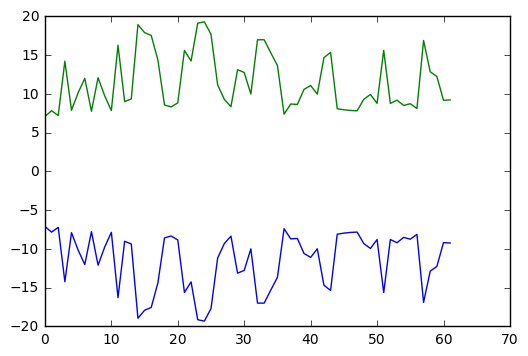

In [171]:
plt.plot(np.mean(np.array(XX_train)[Y_train==1.0,:], 0)[:19*4])
plt.plot(np.mean(np.array(XX_train)[Y_train==0.0,:], 0)[:19*4])

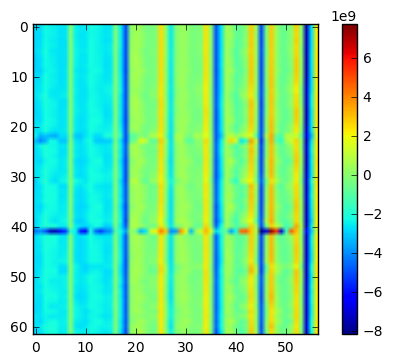

In [126]:
idxs = [i for i,f in enumerate(f_dict) if (('SE' in f))]

#print [full_dict[i] for i in idxs]

plt.imshow(f_spk[3][:,idxs])

plt.colorbar()